# 📘 Historical Evolution of AI Research - A Decade-Wise Comparative Analysis

---

This notebook is part of the **Gemini 1.5 Long Context competition**, demonstrating how the model's long context window enables the analysis of a large set of scientific literature spanning decades. The goal is to uncover trends, paradigm shifts, and developments within the field of Artificial Intelligence (AI) by analyzing thousands of research papers, books, and conference proceedings from the 1970s to today.

---

## 📝 Introduction

The **Gemini 1.5 model**, with its breakthrough large context window of **2 million tokens**, enables the processing of vast amounts of data in a single context. In this project, we leverage this capability to analyze the evolution of scientific literature in AI over the past 50 years. This analysis covers how research trends, terminologies, and paradigms have shifted from one decade to the next, culminating in the current state of the field.

### Why this is important:

- **Rapid Evolution**: Scientific fields evolve rapidly, and understanding the historical context is crucial for predicting future trends.
- **Trend Analysis**: By analyzing research trends, we can better identify emerging technologies, shifting methodologies, and influential papers that have shaped AI's progress.
- **Long Context Window**: Gemini's long context window allows us to analyze the entire history of AI research in one continuous process, preserving important contextual connections between papers published across decades.

In [2]:
!pip install arxiv

^C


In [3]:
# Import all necessary libraries here.
import arxiv
import pandas as pd

ModuleNotFoundError: No module named 'arxiv'

## 📊 Dataset Overview
The dataset used in this analysis contains a comprehensive collection of AI research papers spanning over 50 years. Sourced from arXiv.org and NeurIPS conference proceedings, it includes metadata such as titles, authors, abstracts, publication dates, and key terms. This structured information allows us to analyze the evolution of AI research and track paradigm shifts within the field.

### Why this dataset is valuable:
- **Comprehensive Coverage**: The dataset spans multiple decades, capturing the progression of AI research from its early stages to the present.
- **Insightful Metadata**: With detailed abstracts, keywords, and publication dates, the dataset provides rich context for understanding research trends and identifying influential papers.
- **Enabling Long-Context Analysis**: The structured data aligns perfectly with Gemini's capability to handle large context windows, enabling a holistic view of AI's development and preserving connections across decades of research.

This dataset is essential for identifying patterns, understanding the evolution of terminology, and uncovering the emerging technologies that shape the future of AI.
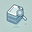

In [ ]:
# Query for AI-related papers from the arXiv API
search_query = 'cat:cs.AI OR cat:stat.ML OR cat:cs.LG'
search = arxiv.Search(
    query=search_query,
    max_results=1000,
    sort_by=arxiv.SortCriterion.SubmittedDate
)

# Fetch and store paper metadata
papers = []
for result in search.results():
    papers.append({
        'title': result.title,
        'authors': [author.name for author in result.authors],
        'abstract': result.summary,
        'published': result.published,
        'categories': result.categories,
        'pdf_url': result.pdf_url
    })


In [ ]:
# After fetching the papers, save the metadata to a CSV file for easier use in Kaggle working directory (/kaggle/working)
df = pd.DataFrame(papers)
df.to_csv('/kaggle/working/arxiv_ai_papers.csv', index=False)

In [ ]:
# Organize by decades to fit our analysis.
df = pd.read_csv('/kaggle/input/arxiv_ai_papers.csv')

# Convert the published date to a datetime format
df['published'] = pd.to_datetime(df['published'])

# Extract the year and create a decade column
df['year'] = df['published'].dt.year
df['decade'] = (df['year'] // 10) * 10

# filter papers from the 1980s
df_1980s = df[df['decade'] == 1980]

print(f"Printing the database from after 1980")
print(df_1980)